# Анализ рынка труда с помощью api hh.ru

In [1]:
# Импортируем библиотеки
import json
import requests

from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

### 1. Проанализирую необходимые навыки для должности аналитика данных.

Тестовые запросы к api hh.ru показали, что ключевые навыки находятся в развернутых карточках вакансий, а поиск по вакансиям выдает их короткие представления. Исходя из этого сформулируем алгоритм действий.
#### Алгоритм действий для получения ключевых навыков из карточек вакансий:
- сделать поисковый запрос и получить короткие представления вакансий;
- в каждой вакансии найти url и сделать запрос для получения полной карточки вакансии;
- в полной карточке вакансии найти ключеные навыки и добавить их в общий список.

In [2]:
# Напишу функцию, которая будет искать ключевые навыки в карточках вакансий
def get_required_skills(response):
    '''
    Функция возвращает ключевые навыки вакансий из поискового запроса.
    
    Функция принимает ответ поискового запроса api headhunter, итерируется
    по каждой вакансии и делает запрос по url вакансии для получения развернутой
    информации по вакансии. Все записи из поля ключевые навыки добавляются
    в список region_required_skills, который и возвращает функция.
    '''
    region_required_skills = []
    
    for vacancy in json.loads(response.text)['items']:
        vacancy_url = vacancy['url']
        vacancy_response = requests.get(vacancy_url)
        vacancy_json = json.loads(vacancy_response.text)
        vacancy_skills = [
            skill['name'].lower() for skill in vacancy_json['key_skills']
        ]
        region_required_skills.extend(vacancy_skills)
        
    return region_required_skills

Для получения ключевых навыков будем искать вакансии в 5 крупнейших городах Росии (по населению): Москва, Санкт-Петербург, Новосибирск, Екатеринбург, Казань.




In [3]:
url = 'https://api.hh.ru/vacancies'
params = {
    'text': 'Аналитик данных',
    'area': None,
    'per_page': 100
}
key_skills = []  # Создаем пустой список

for city_code in [1, 2, 4, 3, 88]:
    params['area'] = city_code  # Меняем регион на каждой итерации
    region_response = requests.get(url, params)
    # Добавим результаты в список
    key_skills.extend(get_required_skills(region_response))

In [4]:
print('Общее количество ключевых навыков:', len(key_skills), '\n', '-' * 70)
print('Пример ключевых навыков:', *key_skills[:5], sep='\n\t')

Общее количество ключевых навыков: 3087 
 ----------------------------------------------------------------------
Пример ключевых навыков:
	sql
	постановка задач разработчикам
	разработка технических заданий
	1с
	ms sql


In [5]:
# Посчитаем количество вхождений навыков с помощью класса Counter
# Для удобсва обернем результат в pandas DataFrame
df = pd.DataFrame(Counter(key_skills).items(), columns=['skill', 'count'])

In [6]:
# Отбросим ключевые навыки с единственным вхождением
df = df[df['count'] > 1]
# Добавим колонку с процентным соотношением количества вхождений
df['percent'] = round(df['count'] / df['count'].sum() * 100, 2)

In [7]:
# Выведем топ-10 навыков по количетсву вхождений
top_ten_skills =  df.sort_values('count', ascending=False).head(10)
top_ten_skills

,skill,count,percent
0,sql,203,7.38
7,аналитическое мышление,125,4.54
5,анализ данных,120,4.36
32,ms powerpoint,86,3.13
29,работа с большим объемом информации,81,2.94
6,python,75,2.73
42,ms excel,63,2.29
38,английский язык,54,1.96
30,работа с базами данных,50,1.82
27,аналитика,49,1.78


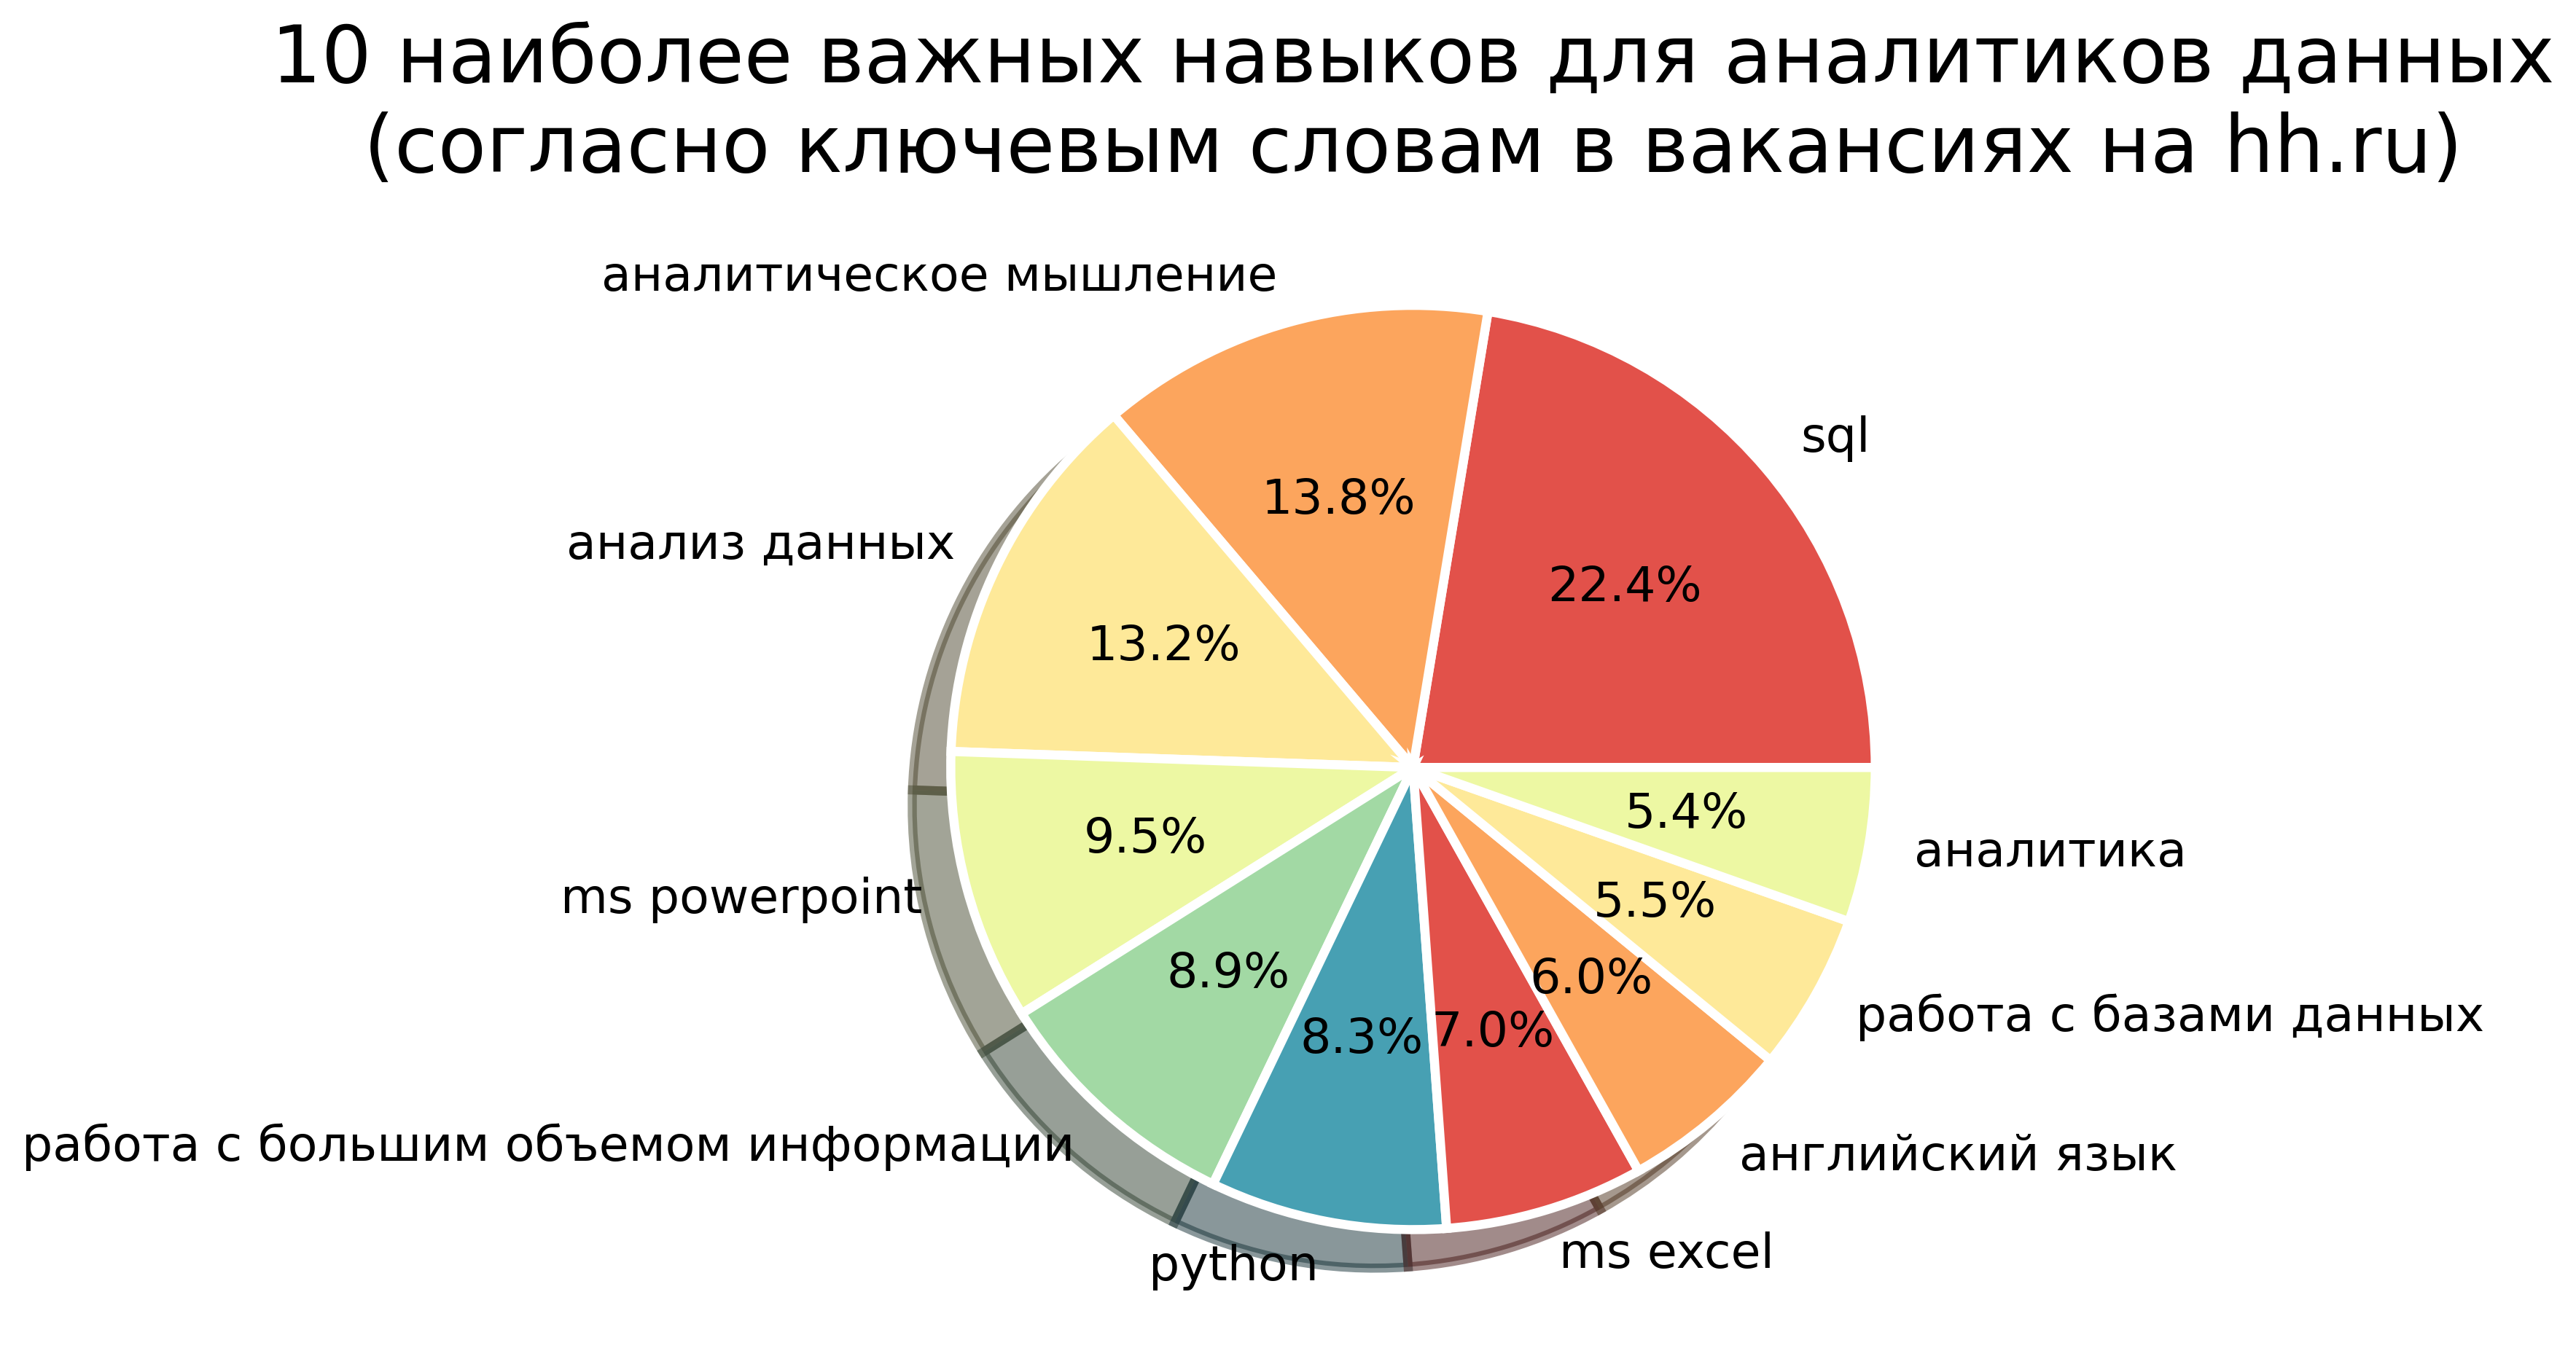

In [8]:
# Визуализируем результаты
fig, axes = plt.subplots(figsize=(15, 7), dpi=300)
colors = sns.color_palette('Spectral')[0:10]
axes.set_title('10 наиболее важных навыков для аналитиков данных\n'
               '(согласно ключевым словам в вакансиях на hh.ru)', fontsize=26)
axes.pie(top_ten_skills['count'], labels=top_ten_skills['skill'],
         autopct='%1.1f%%', shadow=True, textprops={'fontsize': 16},
         colors=colors, wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' })
plt.savefig('top_ten_key_skills.jpg')  # Сохраняем изображение
plt.show()

### Выводы по первой части:
Во многих вакансиях на должность аналитика данных требуется знание SQL, python, MS powerpoint и MS excel, наличие аналитического мышления, умение работать с большим объемом информации и значние английского языка. Меня удивило, что в ключевых словах MS PowerPoint встречается чаще MS Excel.

## 2. Сравним размер з/п аналитиков данных в разных регионах страны

In [9]:
# Напишем функцию, которая будет искать заработные платы в карточках вакансий
def get_region_salaries(response):
    '''
    Функция возвращает ориентировочную з/п по карточке вакансии.
    
    Функция принимает ответ от api hh.ru и итерируется по карточкам вакансий.
    В каждой вакансии ищется заработная вилка, если з/п указана до вычета
    налогов, то из нее вычитается 13 процентов. Размер з/п считается как средняя
    между значением "от" до значения "до" и округляется до целого. Если в карточке
    вакансии указано только одно значение (либо "от", либо "до"), то оно и берется
    в качестве итогового значения.
    '''
    region_salaries = []
    
    for vacancy in json.loads(response.text)['items']:
        salary_from, salary_to = vacancy['salary']['from'], vacancy['salary']['to']
        
        if vacancy['salary']['gross']:  # Вычтем 13 процентов если з/п gross
            if salary_from:  # Проверяем, чтобы не было None-ов
                salary_from *= 0.87
            if salary_to:
                salary_to *= 0.87
                
        salary_range = [i for i in (salary_from, salary_to) if i]
        salary = round(sum(salary_range) / len(salary_range))
        region_salaries.append(salary)    
    return region_salaries

In [10]:
url = 'https://api.hh.ru/vacancies'
params = {
    'text': 'Аналитик данных',
    'area': None,
    'per_page': 100,
    'currency': 'RUR',  # Устанавливаем валюту
    'only_with_salary': True  # Ищем только вакансии с указанной з/п
}
cities = {
    1: 'Москва',
    2: 'Санкт-Петербург',
    4: 'Новосибирск',
    3: 'Екатеринбург',
    88: 'Казань'
}
salaries = {}
response = requests.get(url, params)

for city_code in [1, 2, 4, 3, 88]:
    params['area'] = city_code  # Меняем регион на каждой итерации
    region_response = requests.get(url, params)
    salaries[cities[city_code]] = get_region_salaries(region_response)

In [18]:
salaries_df = pd.DataFrame(salaries.values()).T
salaries_df.columns = salaries.keys()
salaries_df

,Москва,Санкт-Петербург,Новосибирск,Екатеринбург,Казань
0,200000.0,135000.0,100000.0,108750.0,108750.0
1,155000.0,108750.0,90000.0,175000.0,80000.0
2,130000.0,100000.0,120000.0,32500.0,36975.0
3,120000.0,150000.0,60000.0,200000.0,200000.0
4,160000.0,95000.0,45000.0,80000.0,30000.0
...,...,...,...,...,...
95,78000.0,40000.0,NaN,135000.0,NaN
96,65363.0,150000.0,NaN,60750.0,NaN
97,60000.0,3500.0,NaN,52500.0,NaN
98,90000.0,47500.0,NaN,70000.0,NaN


Заметим, что для Новосибирска и Казани у нас присутствуют значения NaN, это вызвано тем, что мы берем 100 первых вакансий из поиска, а в этих городах их оказалось меньше, в принципе это не сильно повлияет на результат, если учесть это при расчетах.

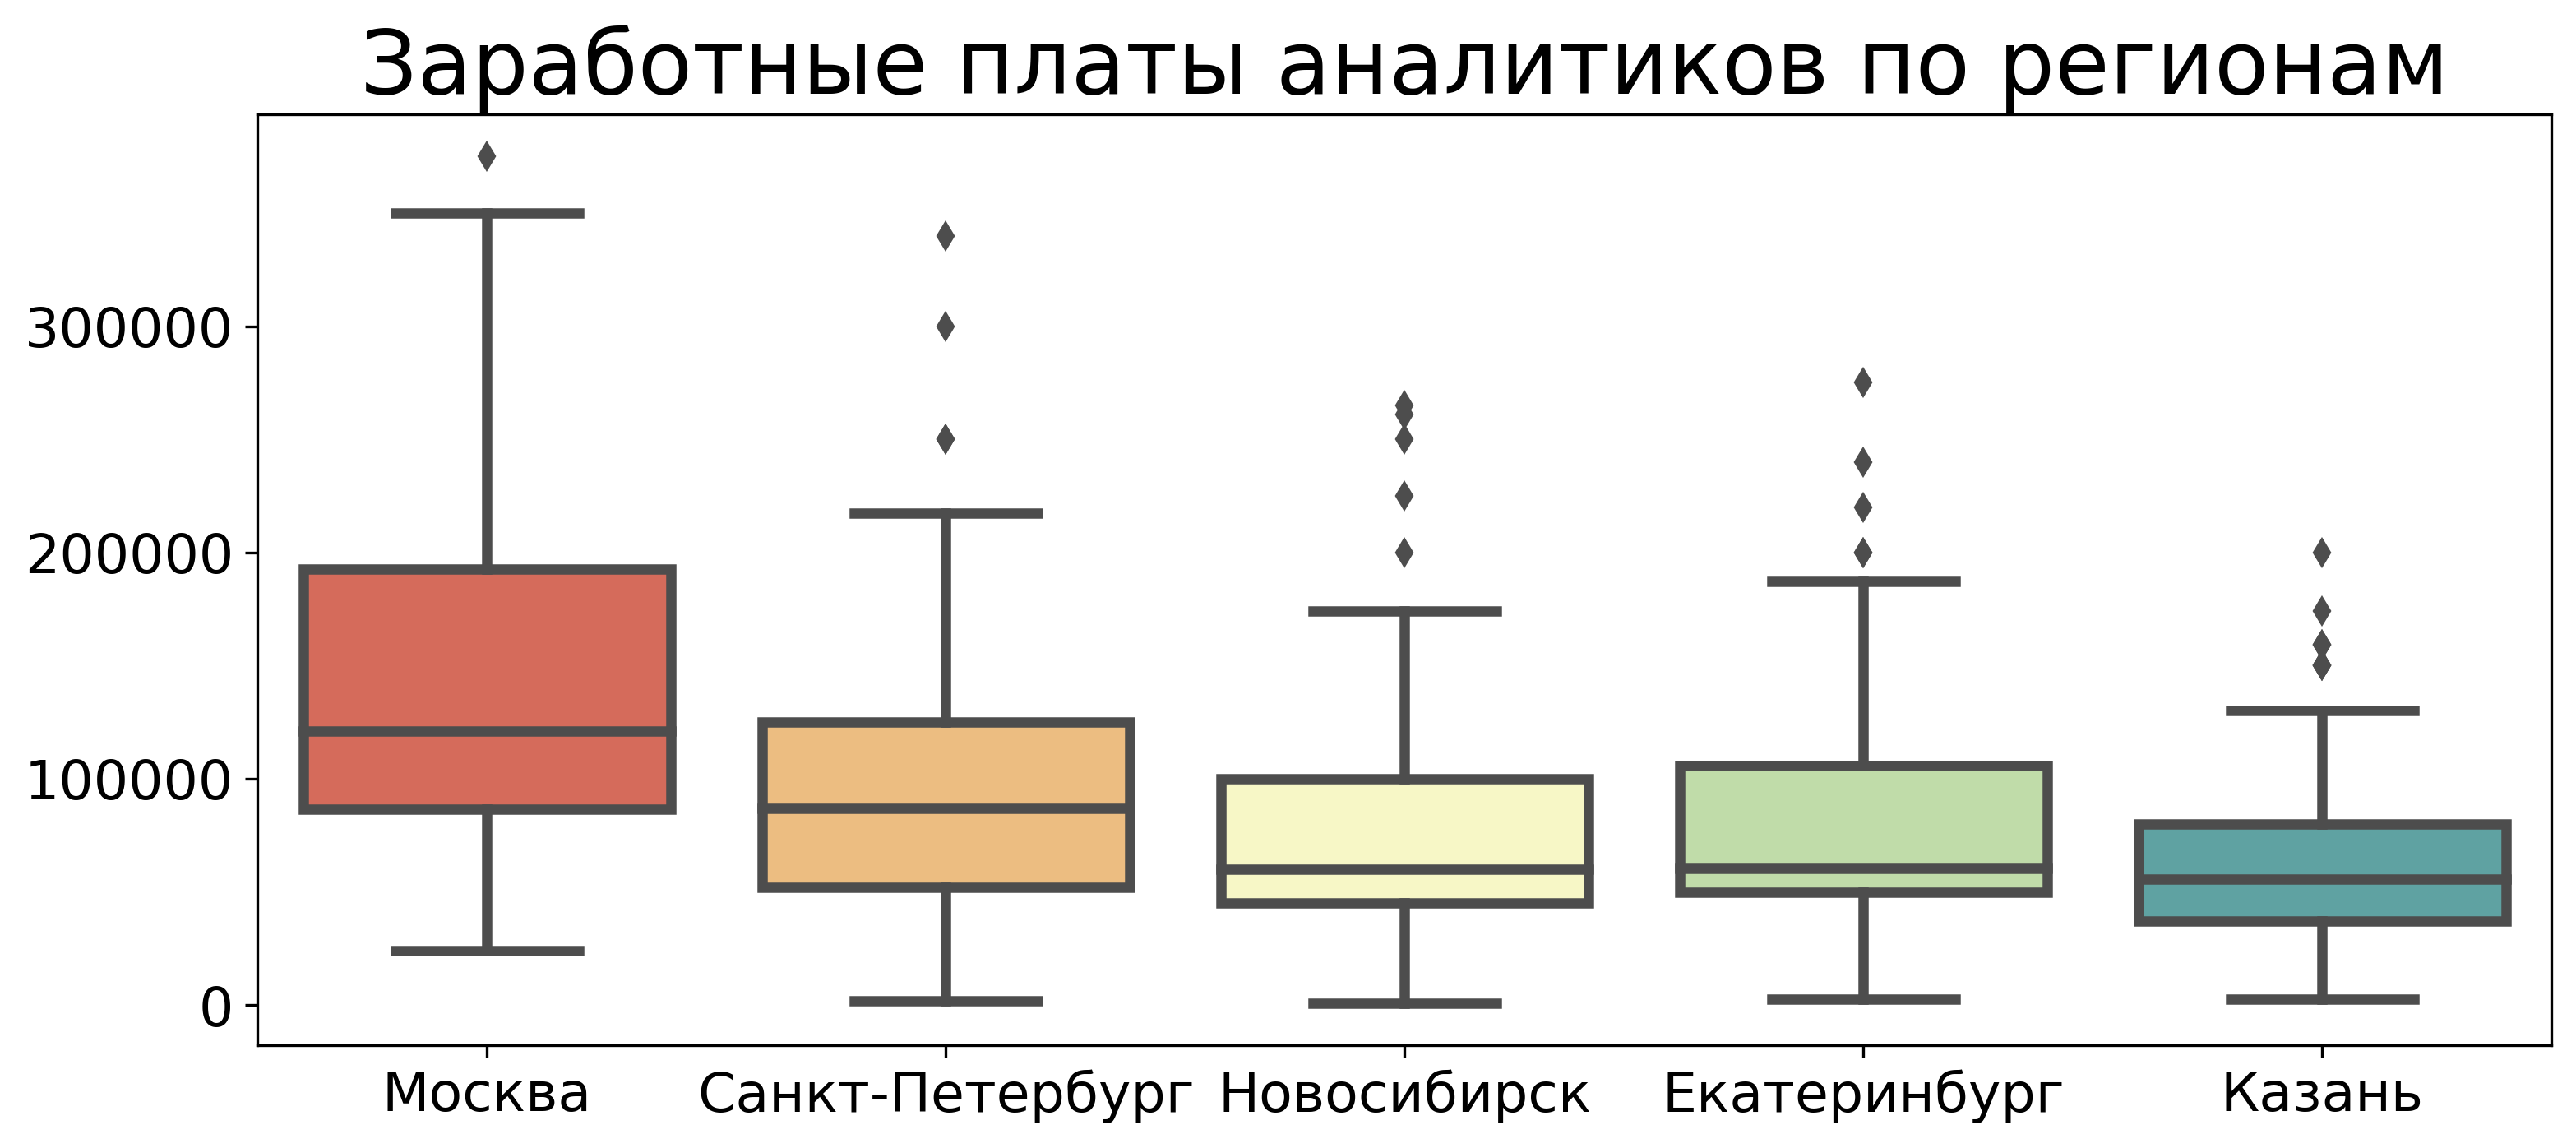

In [19]:
# Визуализируем результаты
fig, axes = plt.subplots(figsize=(12, 5), dpi=300)
sns.boxplot(data=salaries_df, ax=axes, palette='Spectral', linewidth=3)
axes.set_title('Заработные платы аналитиков по регионам', fontsize=26)
axes.tick_params(labelsize=16)

На графике видно, что во всех городах присутствуют выбросы в виде больших заработных плат. Это объясняется наличием вакансий на позиции уровня Senior и/или на должность Teamlead, присутствием на рынке иностранных компаний, з/п в которых обычно выше, а также тем, что некоторые компании закладывают в размер з/п различные компенсации и бонусы.

Также при анализе значений датафрейма я обнаружил несколько очень маленьких значений в районе 500-1000 рублей, скорее всего работодатели ошиблись валютой или не дописали один ноль.

Для наших целей примем за порог отсечения выбросов уровень 5 процентиля снизу и  95 процентиля сверху.

In [20]:
# Для каждого города оставляем значения больше 5 и меньше 95 процентиля
for city in salaries_df.columns:
    salaries_df[city] = salaries_df[city][
        (salaries_df[city].quantile(0.05) < salaries_df[city]) &
        (salaries_df[city] < salaries_df[city].quantile(0.95))
    ]
# quantile игнорирует значения NaN, так что проблем не возникло

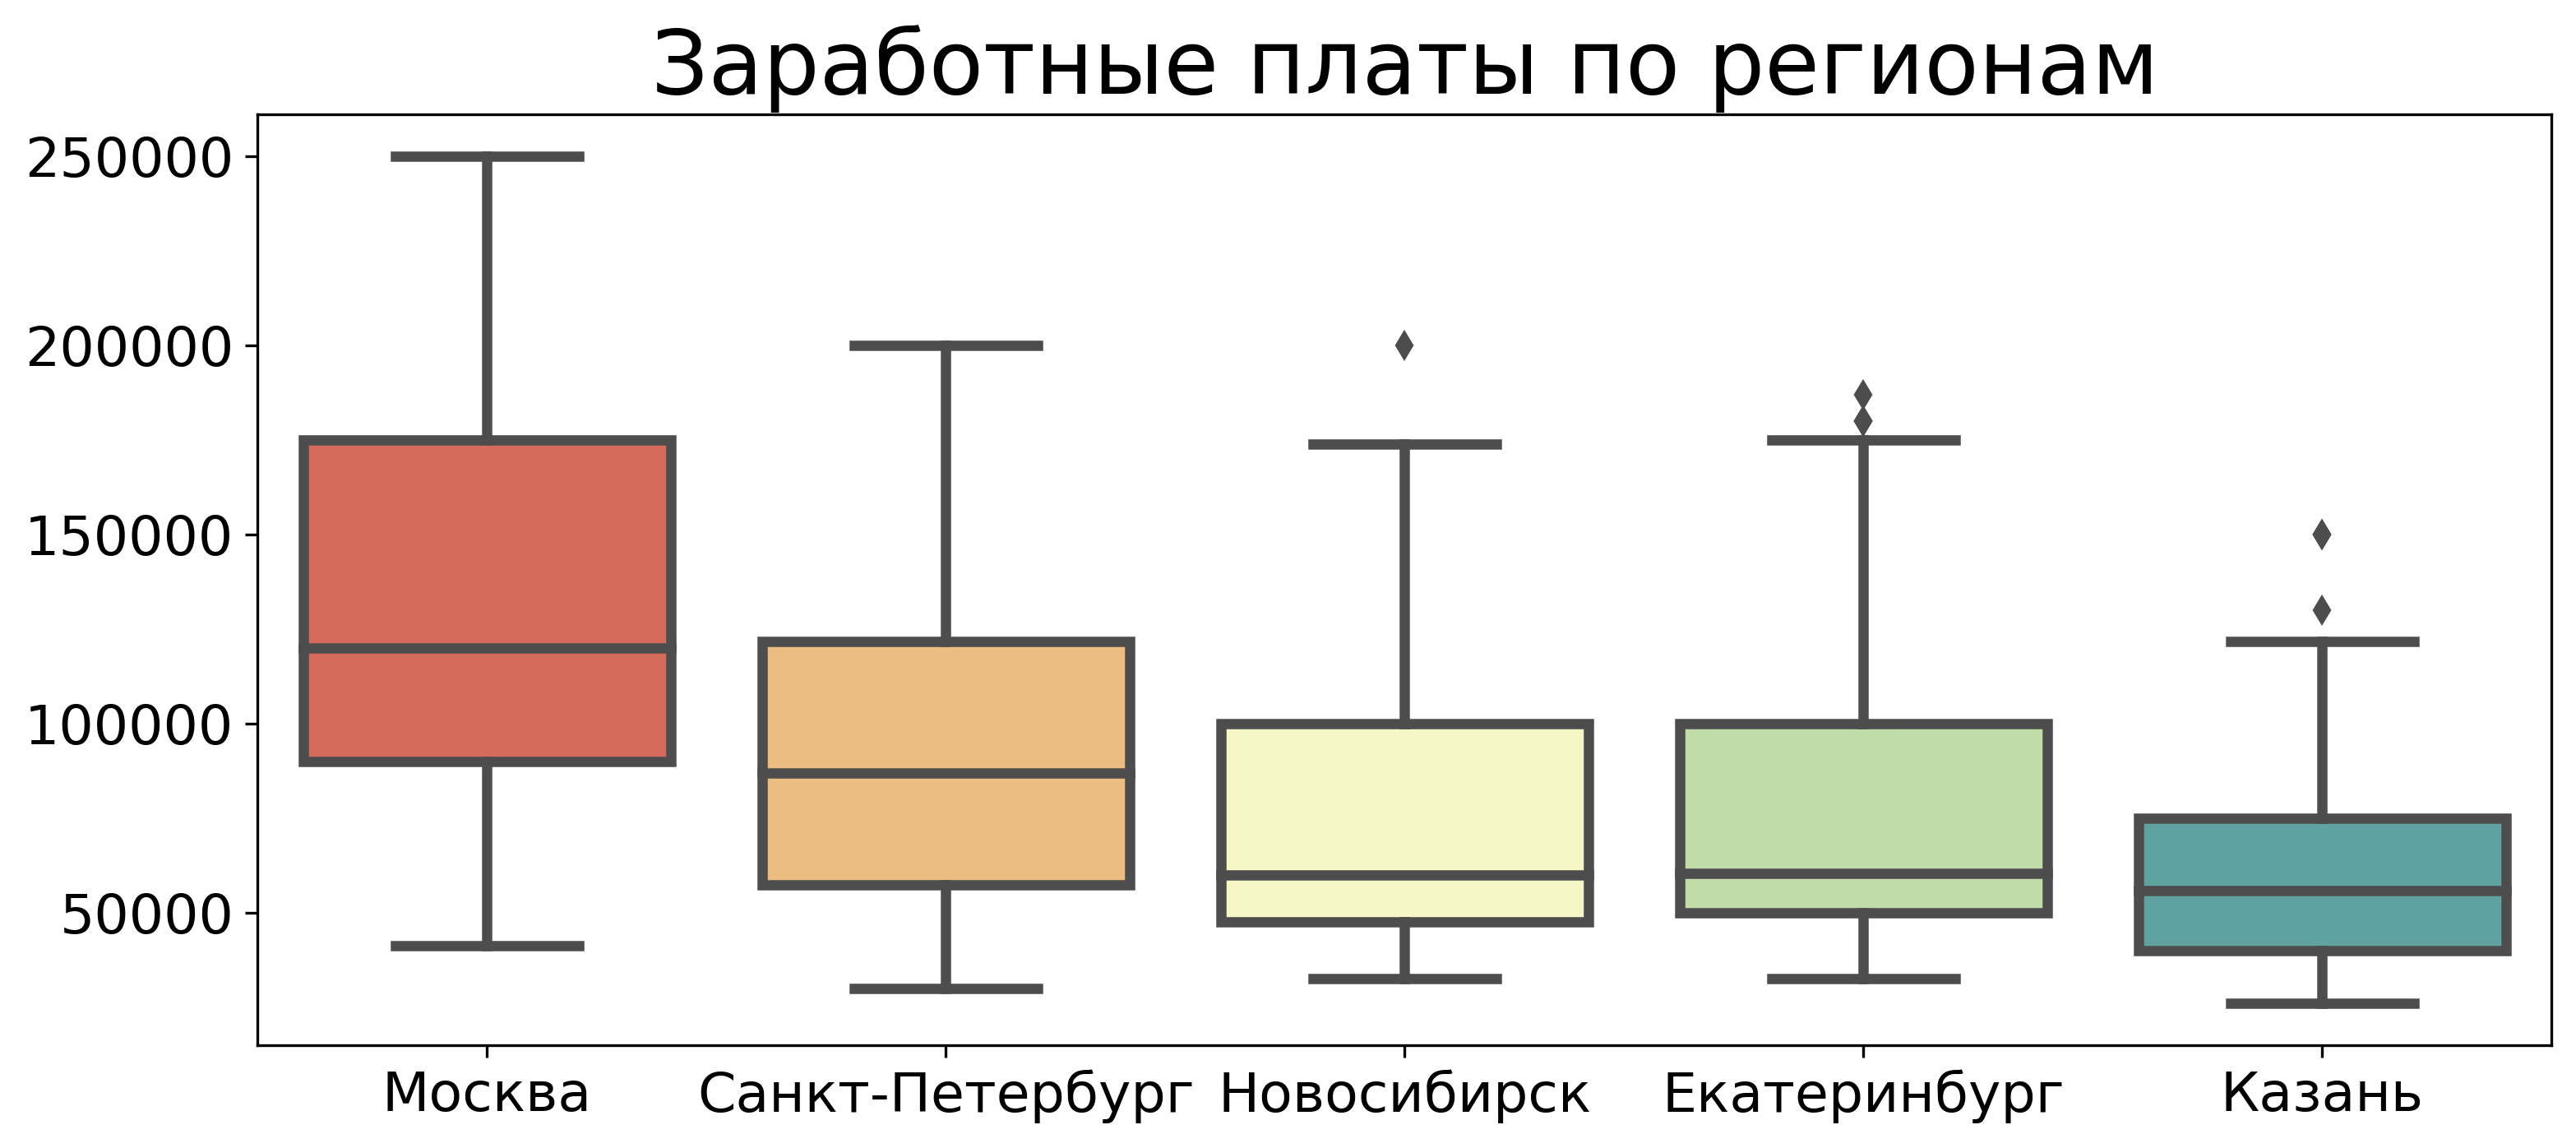

In [23]:
# Построим наш график повторно
fig, axes = plt.subplots(figsize=(12, 5), dpi=300)
sns.boxplot(data=salaries_df, ax=axes, palette='Spectral',
           linewidth=3)
axes.set_title('Заработные платы по регионам', fontsize=26)
axes.tick_params(labelsize=16)

Уже лучше, теперь построим гистограммы заработных плат для каждого региона и посмотрим на результат

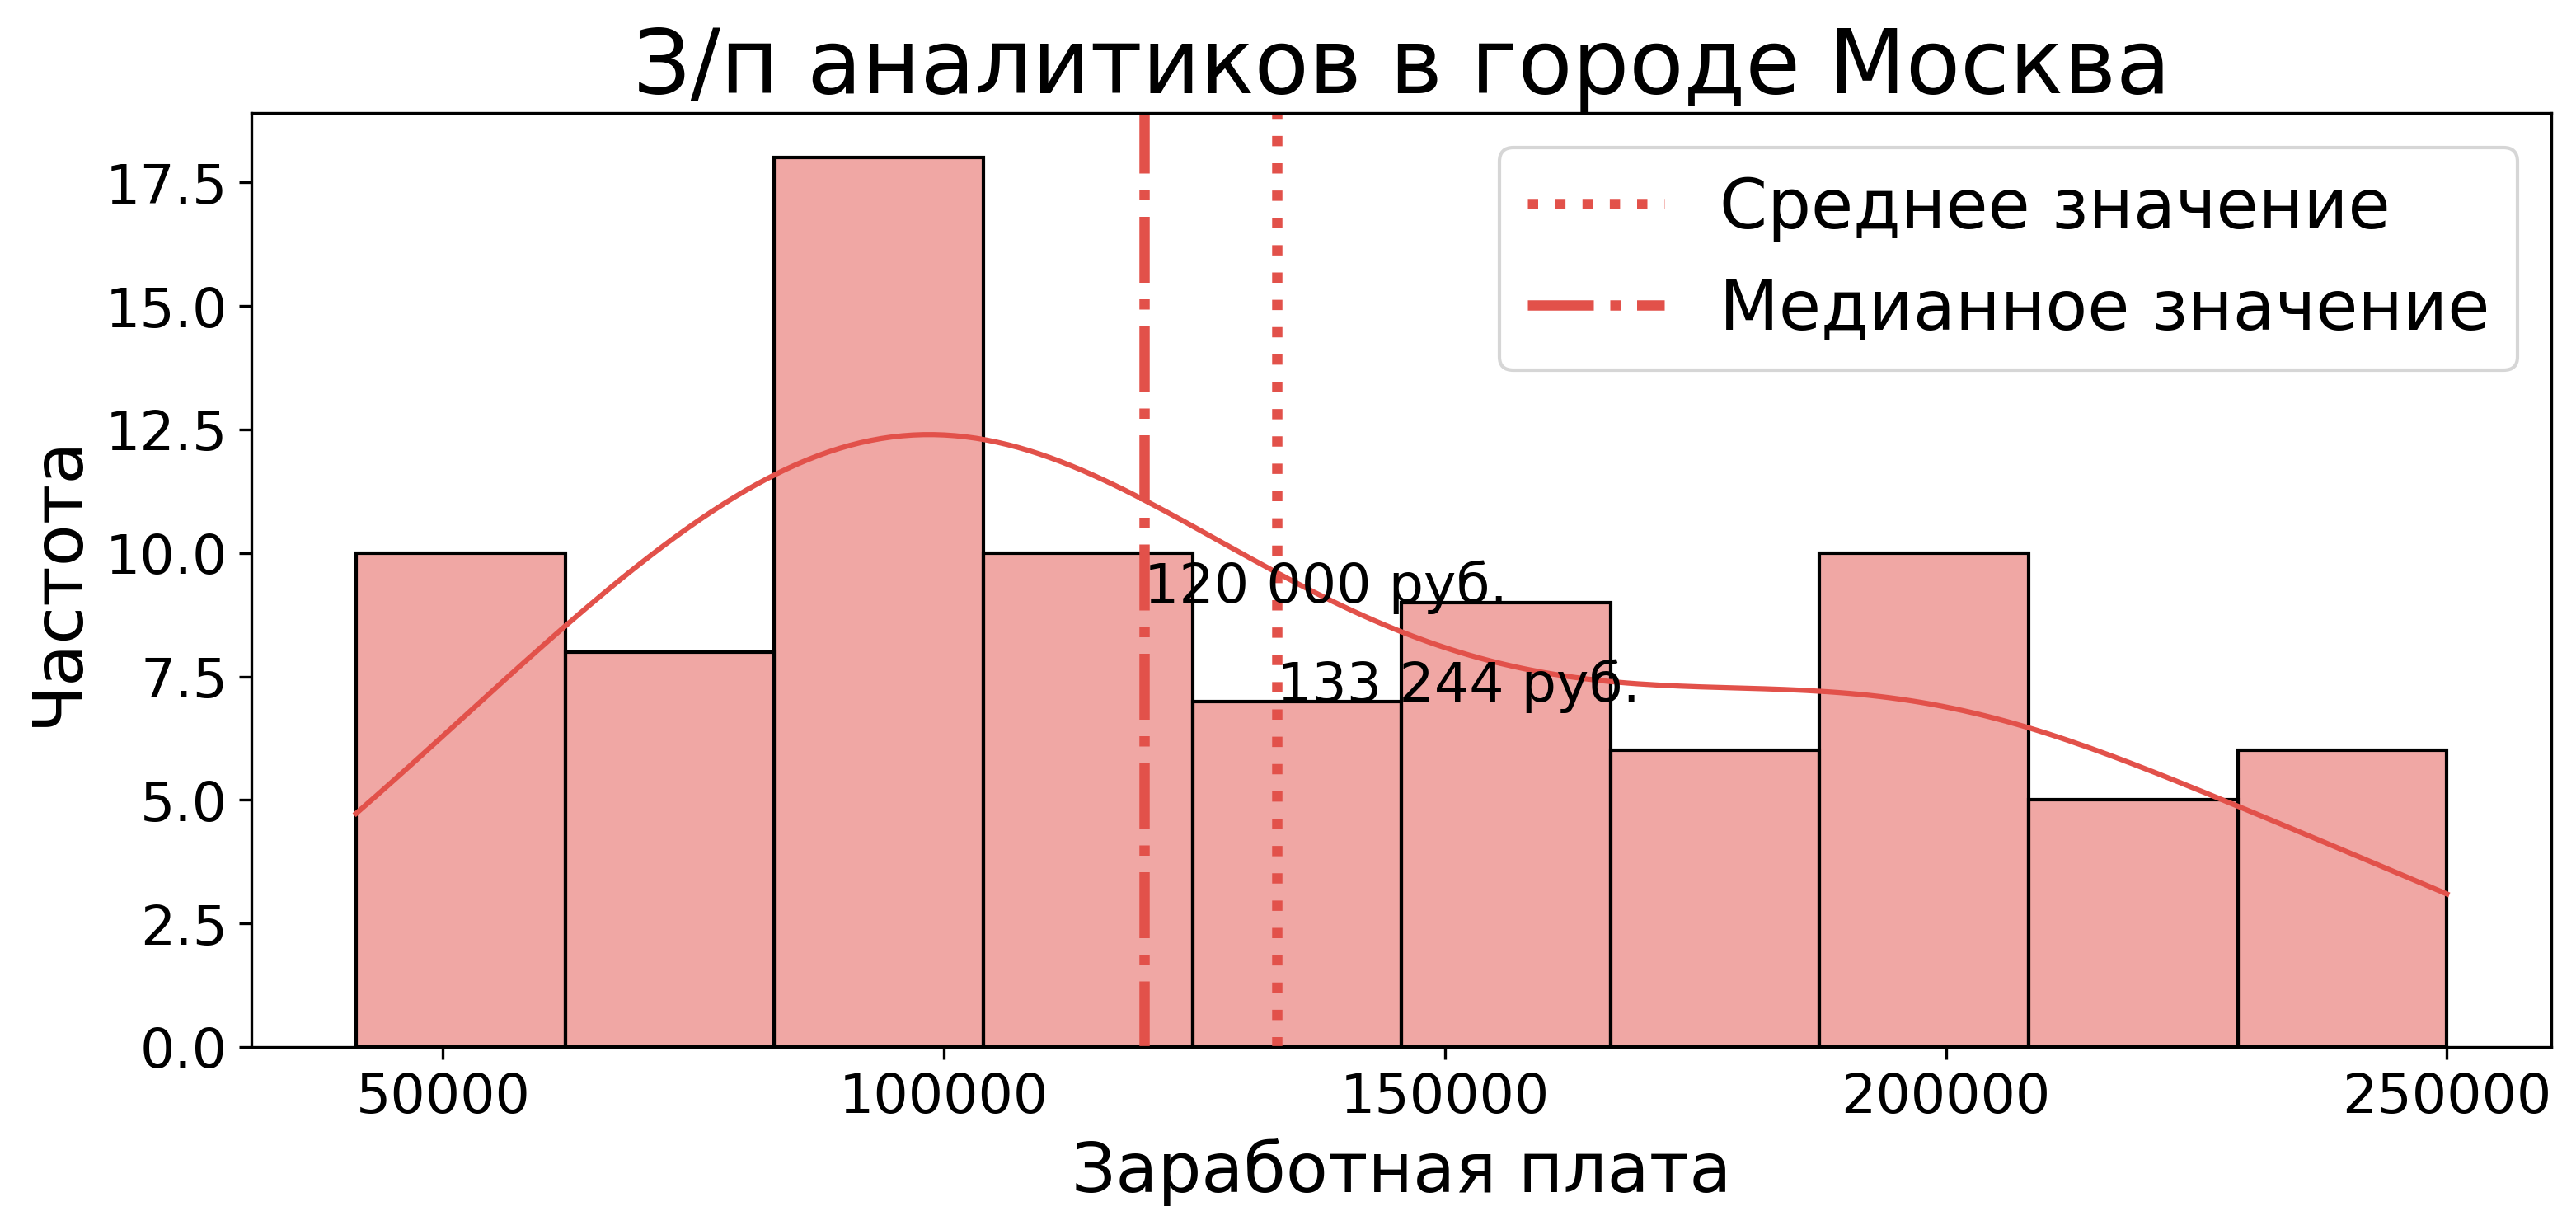

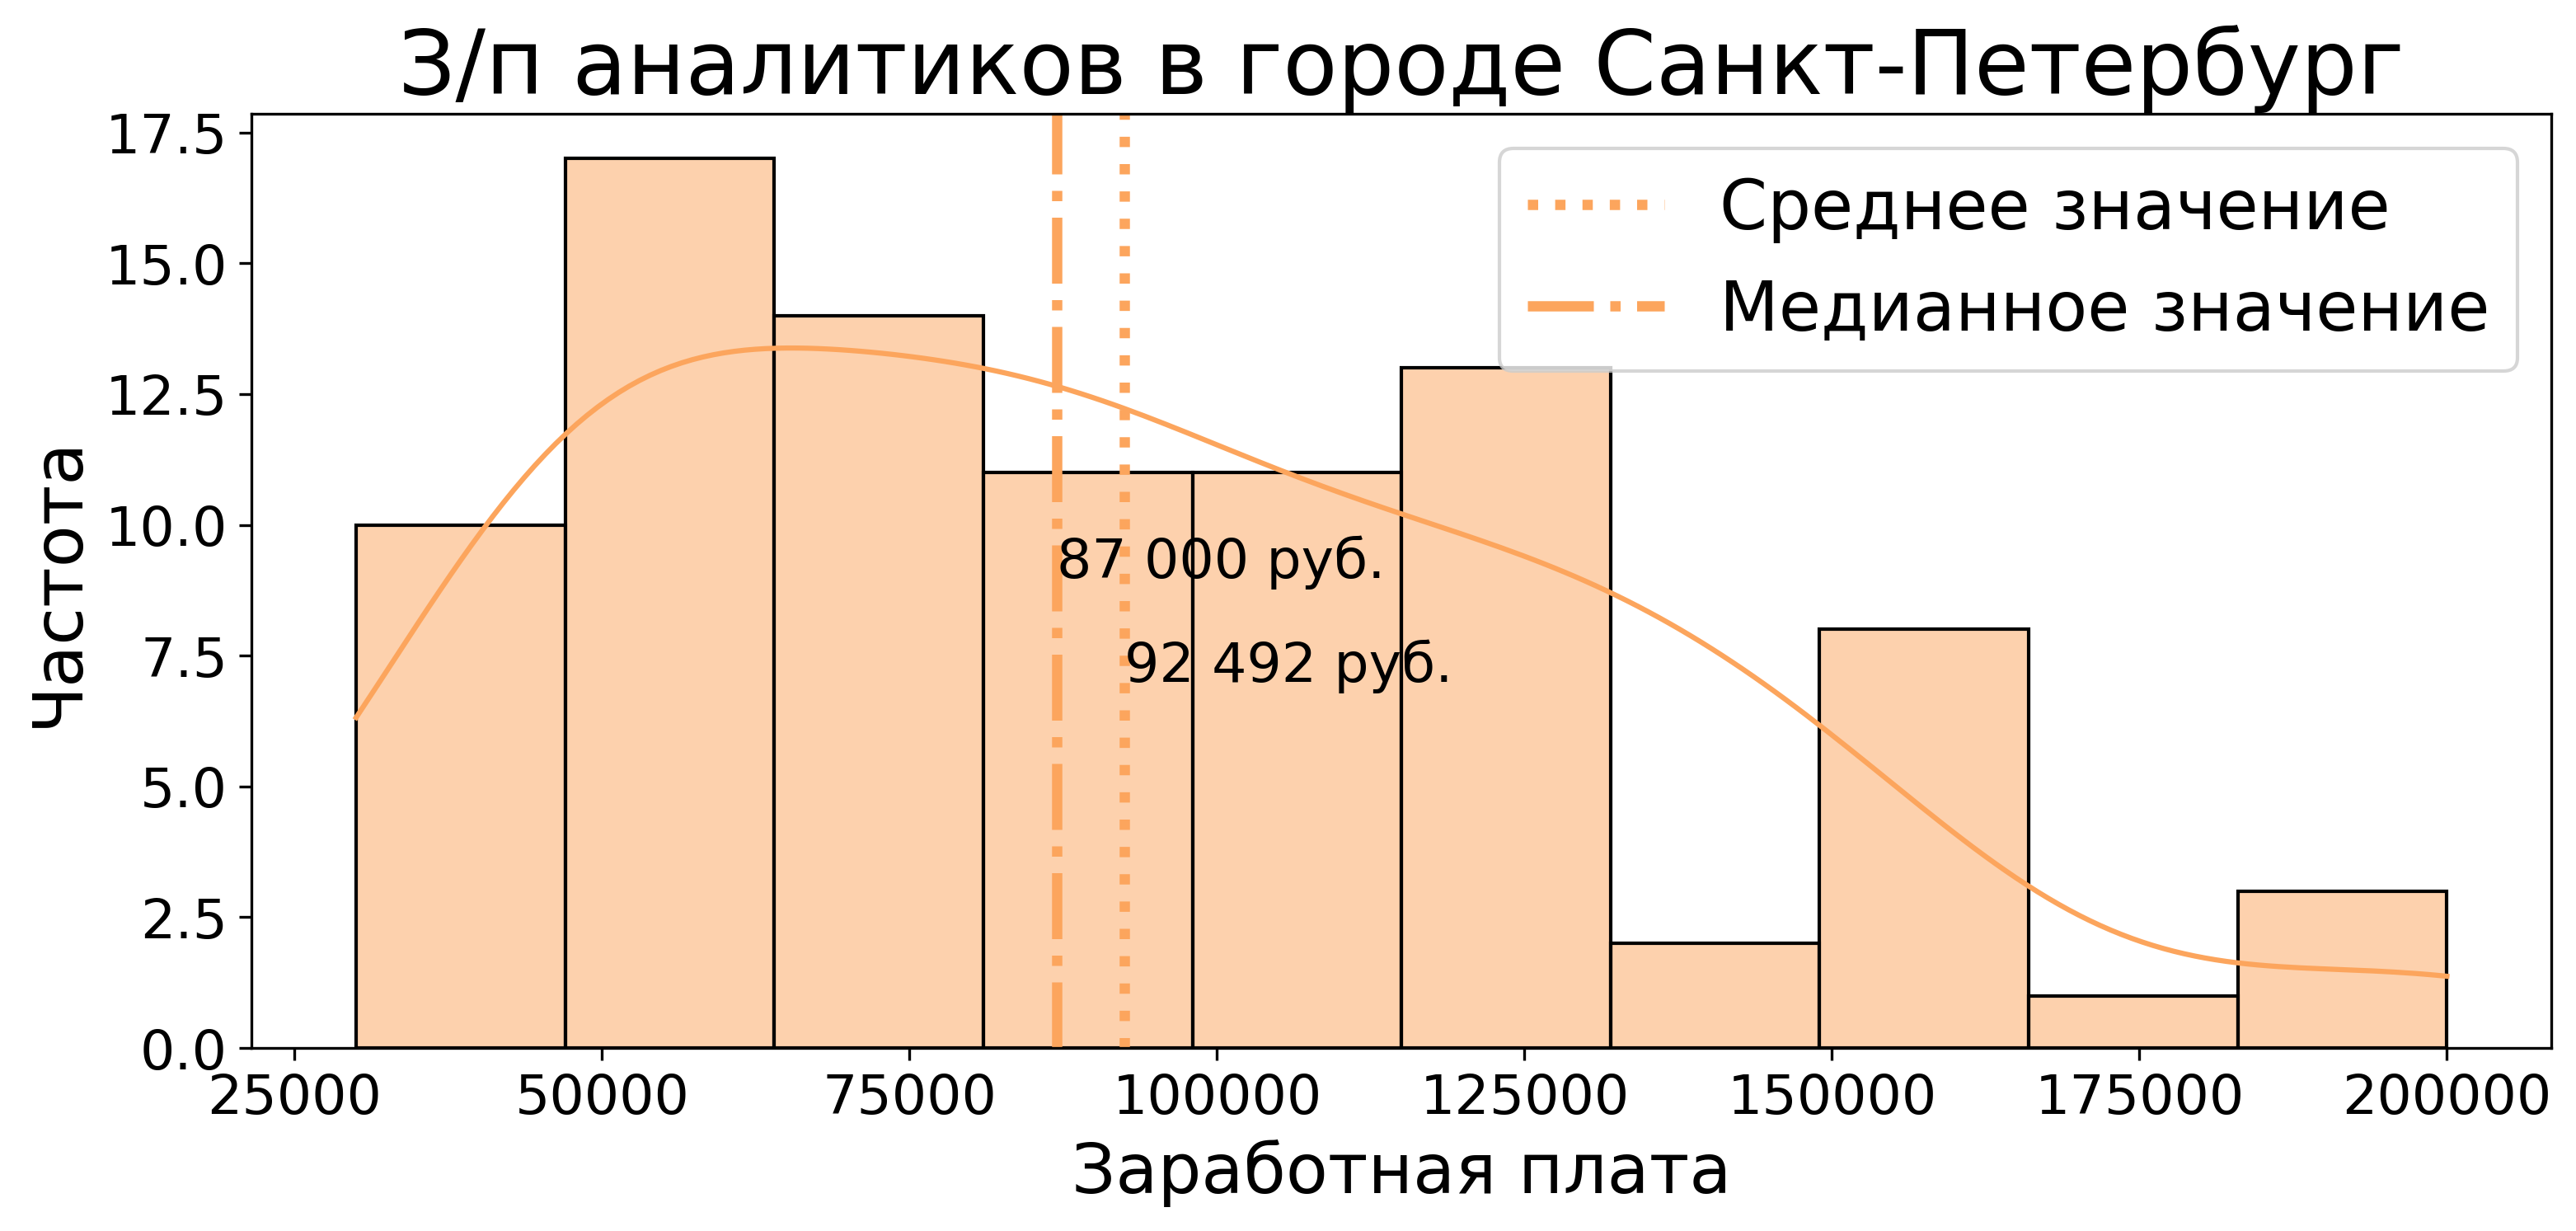

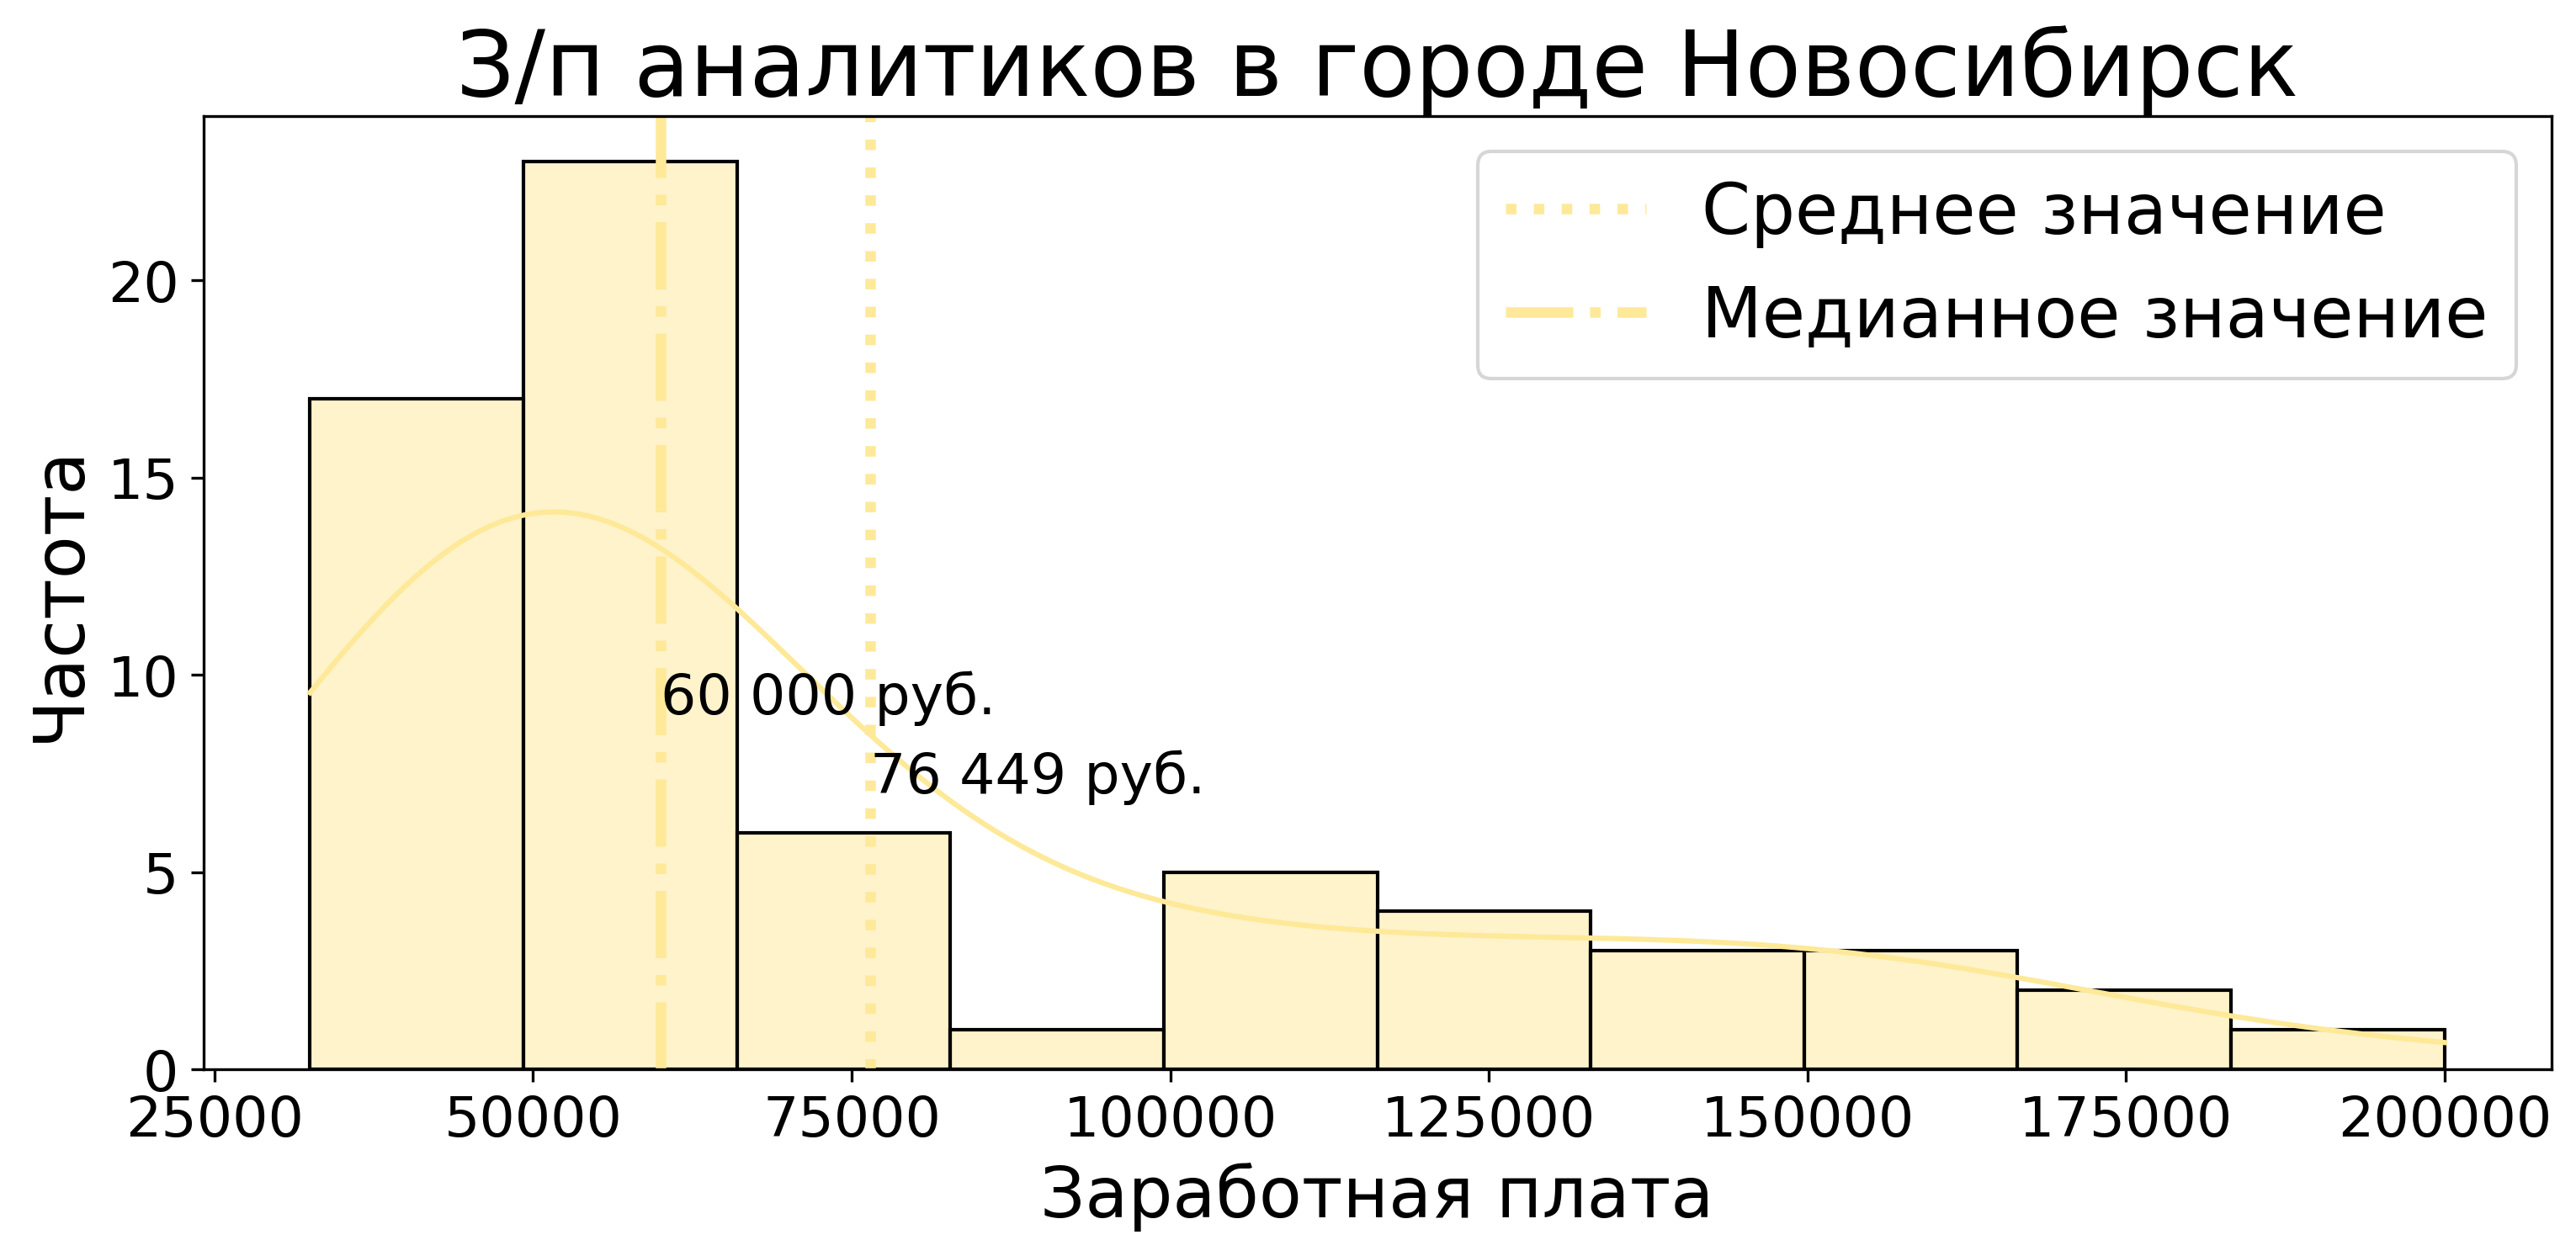

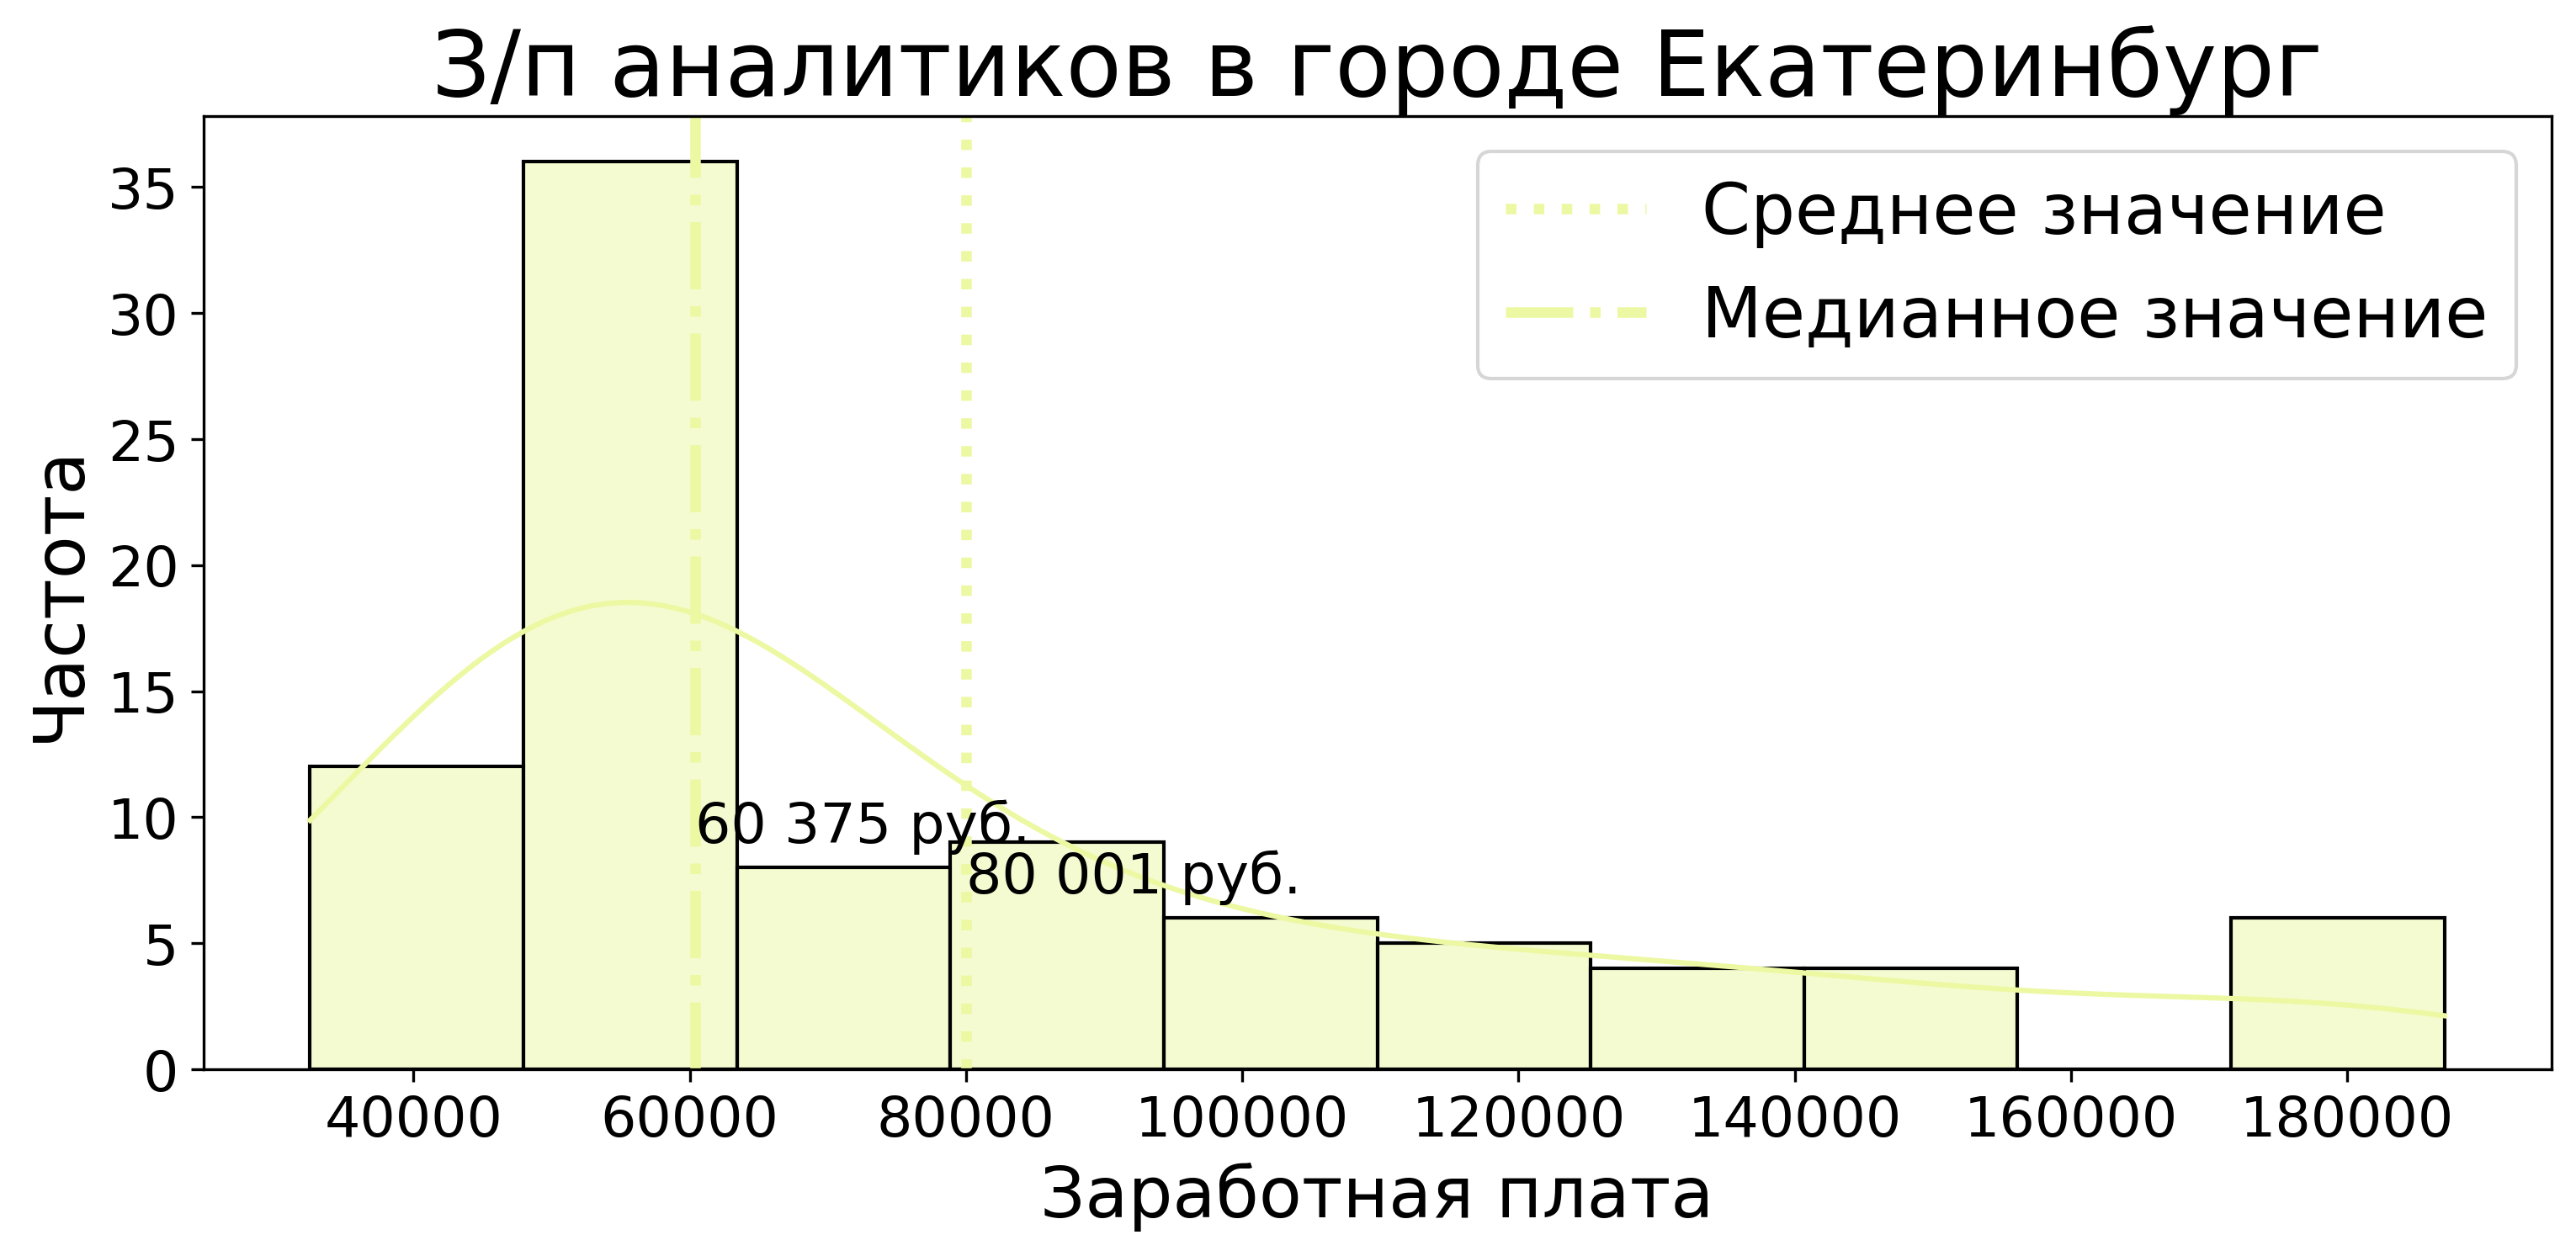

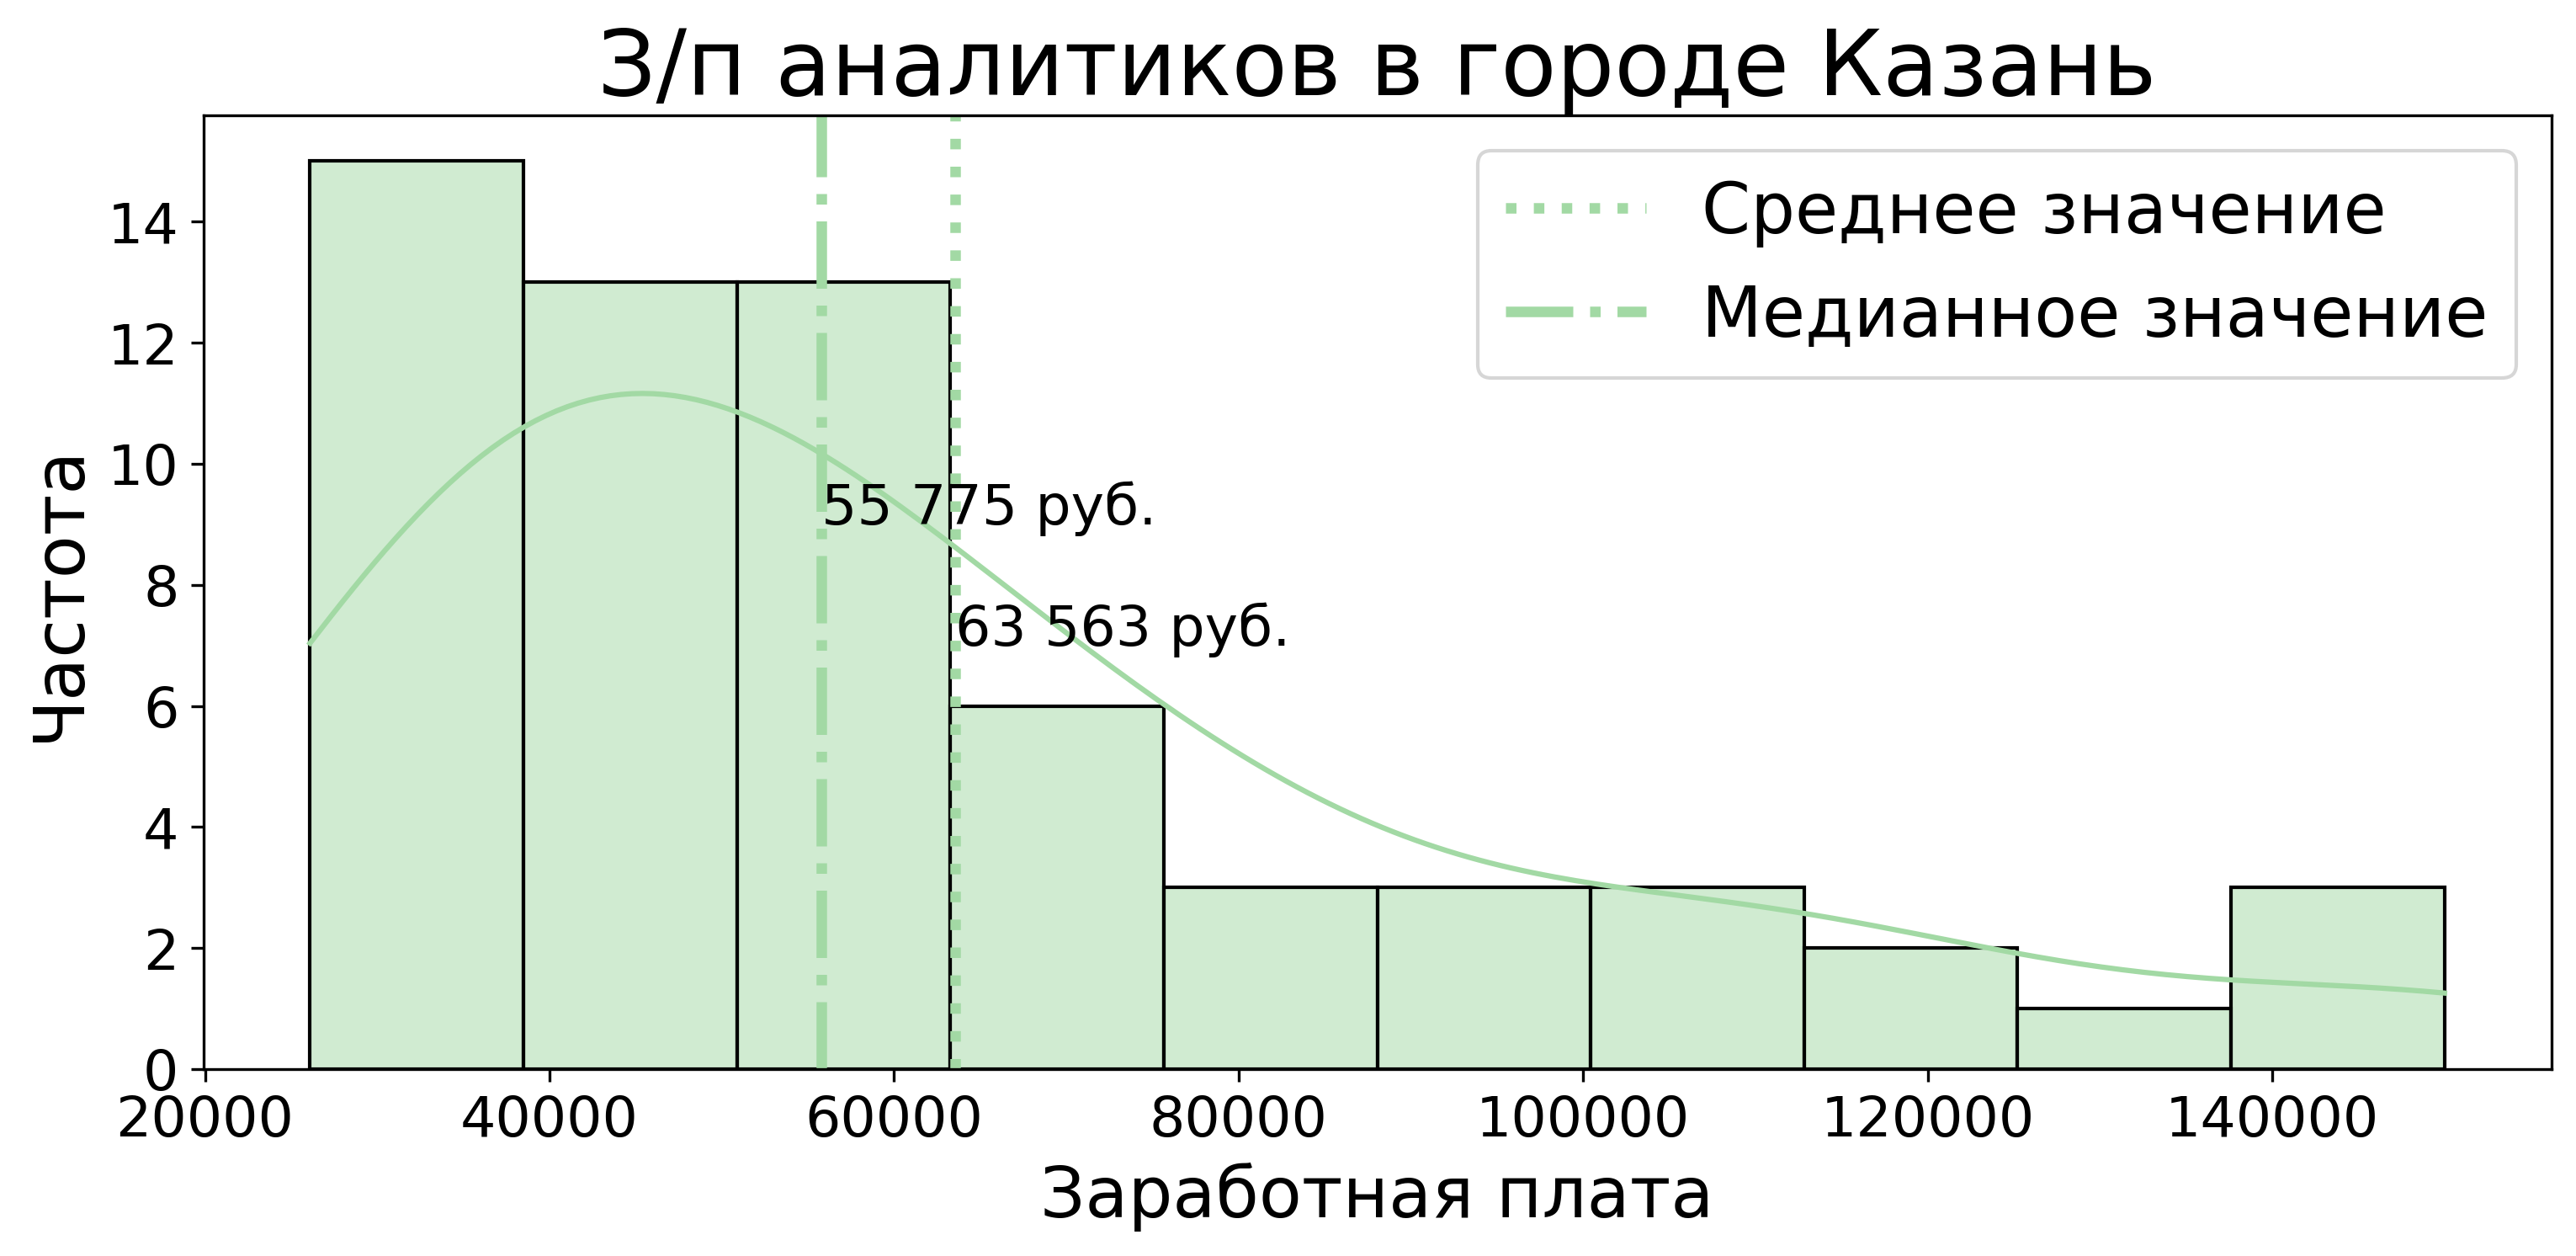

In [24]:
# Строим гистограммы для каждого региона
colors = sns.color_palette('Spectral')[0:10]
for color, city in enumerate(salaries_df.columns):
    fig, axes = plt.subplots(figsize=(12, 5), dpi=300)
    axes.set_title(f'З/п аналитиков в городе {city}', fontsize=26)
    axes.set_xlabel(f'Заработная плата', fontsize=20)
    axes.set_ylabel(f'Частота', fontsize=20)
    color = colors[color]
    sns.histplot(salaries_df[city], kde=True, bins=10, color=color,
                 label='_nolegend_')
    axes.axvline(salaries_df[city].mean(), linestyle='dotted',
                 color=color, linewidth=3, label='Среднее значение')
    plt.text(salaries_df[city].mean(), 7, 
             f'{round(salaries_df[city].mean()):_} руб.'.replace('_', ' '),
            fontsize=16)
    axes.axvline(salaries_df[city].median(), linestyle='dashdot',
                 color=color, linewidth=3, label='Медианное значение')
    plt.text(salaries_df[city].median(), 9, 
             f'{round(salaries_df[city].median()):_} руб.'.replace('_', ' '),
            fontsize=16)
    axes.tick_params(labelsize=16)
    axes.legend(prop={'size': 20})
    plt.savefig(f'{city}_salary.jpg')  # Сохраняем результат в файл
    plt.show()

### Выводы по второй части:
На данных графиках наглядно демонстририуется, почему когда мы имеем дело с деньгами для описания распределения лучше использовать медианное значение, а не среднее, так как среднее очень чувствительно к большим значениям. Также нужно быть внимательным при работе с пропущенными значениями и уделять внимание выбросам, так как эти факторы могут сильно влиять на результат.